### گزارش نهایی پروژه تشخیص اسپم پیامک
<div dir="rtl">
**نام دانشجو:** ایمان خلیل‌الرحمانی

در این پروژه به منظور تشخیص پیامک‌های اسپم، چهار الگوریتم یادگیری ماشین شامل نزدیک‌ترین همسایه (KNN)، رگرسیون لجستیک (Logistic Regression)، جنگل تصادفی (Random Forest) و XGBoost بر روی مجموعه داده پیامک‌ها پیاده‌سازی و ارزیابی شد.  
برای هر یک از مدل‌ها، با استفاده از روش جستجوی شبکه‌ای (GridSearchCV) بهینه‌ترین پارامترها تعیین گردید و عملکرد مدل‌ها با استفاده از اعتبارسنجی متقاطع ده‌لایه‌ای (10-fold cross validation) مورد سنجش قرار گرفت.

**پارامترهای بهینه انتخاب شده برای هر مدل به شرح زیر است:**

- **KNN:** تعداد همسایه = ۱  
- **Logistic Regression:** مقدار C = ۱۰۰  
- **Random Forest:** تعداد درخت = ۲۰۰ ، عمق درخت = نامحدود (None)
- **XGBoost:** با تنظیمات بهینه‌شده پیش‌فرض (پارامترهای تنظیم‌شده با GridSearchCV)

**نتایج میانگین دقت و انحراف معیار مدل‌ها بر اساس اعتبارسنجی ۱۰-لایه‌ای:**

| مدل                  | میانگین دقت | انحراف معیار دقت |
|----------------------|-------------|------------------|
| KNN                  | 0.9587      | 0.0060           |
| Logistic Regression  | 0.9846      | 0.0043           |
| Random Forest        | 0.9826      | 0.0060           |
| XGBoost              | 0.9747      | 0.0055           |

### تحلیل نتایج:

بر اساس نتایج به‌دست‌آمده، مدل رگرسیون لجستیک (Logistic Regression) با دقت میانگین **0.9846** و انحراف معیار **0.0043**، بهترین عملکرد را در بین مدل‌های بررسی‌شده ارائه داده است. پس از آن، مدل جنگل تصادفی (Random Forest) با دقت بسیار نزدیک **0.9826** قرار دارد.  
مدل XGBoost با وجود عملکرد قابل قبول (**0.9747**)، نسبت به دو مدل قبلی از دقت پایین‌تری برخوردار است. مدل KNN نیز با وجود سادگی، دقت نسبتاً خوبی (**0.9587**) ارائه داده است، اما در رتبه آخر قرار می‌گیرد.

در مجموع، با توجه به دقت بالاتر و پایداری مدل‌های رگرسیون لجستیک و جنگل تصادفی، توصیه می‌شود در کاربردهای عملی تشخیص اسپم، اولویت استفاده با این دو مدل باشد. XGBoost نیز می‌تواند به عنوان یک مدل مکمل مورد بررسی قرار گیرد.  
مدل KNN به‌دلیل سادگی و سرعت بالا، می‌تواند در شرایط خاص مورد استفاده قرار گیرد اما از نظر دقت، نسبت به سایر مدل‌ها ضعیف‌تر عمل می‌کند.
</div>

In [5]:
# ایمپورت کتابخانه‌های لازم
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

print("کتابخانه‌ها با موفقیت ایمپورت شدند.")


کتابخانه‌ها با موفقیت ایمپورت شدند.


In [6]:
# بارگذاری و بررسی اولیه داده‌ها
# فرض بر این است که فایل دیتاست 'spam.csv' در کنار نوت‌بوک است.
df = pd.read_csv('https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv', encoding='latin-1')

# نمایش چند ردیف اول
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
# بررسی و آماده‌سازی دیتا
# حذف ستون‌های اضافی اگر وجود داشت
if df.shape[1] > 2:
    df = df.iloc[:, :2]

df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print('شکل داده‌ها:', df.shape)
df.head()


شکل داده‌ها: (5572, 2)


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


label
0    4825
1     747
Name: count, dtype: int64


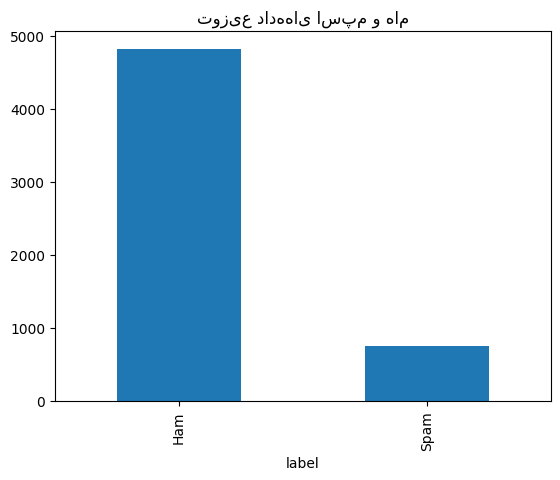

In [8]:
# نمایش آماری تعداد اسپم و غیر اسپم
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title('توزیع داده‌های اسپم و هام')
plt.show()


In [9]:
# پیش‌پردازش متن و تبدیل به ویژگی عددی
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

print("تبدیل متن به ویژگی عددی با موفقیت انجام شد.")


تبدیل متن به ویژگی عددی با موفقیت انجام شد.


In [10]:
# تعریف کراس‌ولیدیشن
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [14]:
# پیدا کردن بهترین پارامتر برای KNN
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
gs_knn.fit(X, y)
print("بهترین مقدار n_neighbors برای KNN:", gs_knn.best_params_)
print("دقت متوسط در 5-fold:", gs_knn.best_score_)


بهترین مقدار n_neighbors برای KNN: {'n_neighbors': 1}
دقت متوسط در 5-fold: 0.9522609108694077


In [15]:
# اجرای KNN با بهترین پارامتر و 10-fold CV
knn_best = KNeighborsClassifier(n_neighbors=gs_knn.best_params_['n_neighbors'])
knn_scores = cross_val_score(knn_best, X, y, cv=kf, scoring='accuracy')
print("دقت‌های هر Fold با KNN:", knn_scores)
print("دقت میانگین KNN با 10-fold:", knn_scores.mean())


دقت‌های هر Fold با KNN: [0.96236559 0.96057348 0.96409336 0.9551167  0.97127469 0.95332136
 0.95152603 0.95691203 0.96050269 0.95152603]
دقت میانگین KNN با 10-fold: 0.9587211958585099


In [16]:
# پیدا کردن بهترین پارامتر برای Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']}
gs_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
gs_lr.fit(X, y)
print("بهترین مقدار C برای Logistic Regression:", gs_lr.best_params_)
print("دقت متوسط در 5-fold:", gs_lr.best_score_)


بهترین مقدار C برای Logistic Regression: {'C': 100, 'solver': 'liblinear'}
دقت متوسط در 5-fold: 0.9806170145961308


In [17]:
# اجرای Logistic Regression با بهترین پارامتر و 10-fold CV
lr_best = LogisticRegression(C=gs_lr.best_params_['C'], solver='liblinear', max_iter=1000)
lr_scores = cross_val_score(lr_best, X, y, cv=kf, scoring='accuracy')
print("دقت‌های هر Fold با Logistic Regression:", lr_scores)
print("دقت میانگین Logistic Regression با 10-fold:", lr_scores.mean())


دقت‌های هر Fold با Logistic Regression: [0.99103943 0.98207885 0.98204668 0.98922801 0.98384201 0.98563734
 0.98204668 0.97845601 0.99102334 0.98025135]
دقت میانگین Logistic Regression با 10-fold: 0.9845649697882279


In [18]:
# پیدا کردن بهترین پارامتر برای Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
gs_rf.fit(X, y)
print("بهترین پارامترها برای Random Forest:", gs_rf.best_params_)
print("دقت متوسط در 5-fold:", gs_rf.best_score_)


بهترین پارامترها برای Random Forest: {'max_depth': None, 'n_estimators': 200}
دقت متوسط در 5-fold: 0.9797187044625677


In [20]:
# اجرای Random Forest با بهترین پارامتر و 10-fold CV
rf_best = RandomForestClassifier(n_estimators=gs_rf.best_params_['n_estimators'],
                                max_depth=gs_rf.best_params_['max_depth'],
                                random_state=42)
rf_scores = cross_val_score(rf_best, X, y, cv=kf, scoring='accuracy')
print("دقت‌های هر Fold با Random Forest:", rf_scores)
print("دقت میانگین Random Forest با 10-fold:", rf_scores.mean())


دقت‌های هر Fold با Random Forest: [0.98207885 0.97670251 0.97845601 0.99281867 0.98743268 0.97486535
 0.98384201 0.97486535 0.98922801 0.98563734]
دقت میانگین Random Forest با 10-fold: 0.9825926783910222


In [22]:
# سلول: پیدا کردن بهترین پارامترهای XGBoost با GridSearchCV

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

gs_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='accuracy'
)
gs_xgb.fit(X, y)

print("بهترین پارامترهای XGBoost:", gs_xgb.best_params_)
print("دقت متوسط 5-fold:", gs_xgb.best_score_)


بهترین پارامترهای XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
دقت متوسط 5-fold: 0.9743346402492532


In [24]:
#  اجرای XGBoost با بهترین پارامترها و 10-fold Cross Validation

xgb_best = XGBClassifier(
    n_estimators=gs_xgb.best_params_['n_estimators'],
    max_depth=gs_xgb.best_params_['max_depth'],
    learning_rate=gs_xgb.best_params_['learning_rate'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_scores = cross_val_score(xgb_best, X, y, cv=kf, scoring='accuracy')

print("دقت‌های هر Fold با XGBoost:", xgb_scores)
print("دقت میانگین XGBoost با 10-fold:", xgb_scores.mean())


دقت‌های هر Fold با XGBoost: [0.98387097 0.96774194 0.96409336 0.98025135 0.97486535 0.97307002
 0.97307002 0.97486535 0.97845601 0.97666068]
دقت میانگین XGBoost با 10-fold: 0.9746945039671049


                 Model  Mean Accuracy  Std Accuracy
0                  KNN       0.958721      0.005961
1  Logistic Regression       0.984565      0.004264
2        Random Forest       0.982593      0.005953
3              XGBoost       0.974695      0.005470


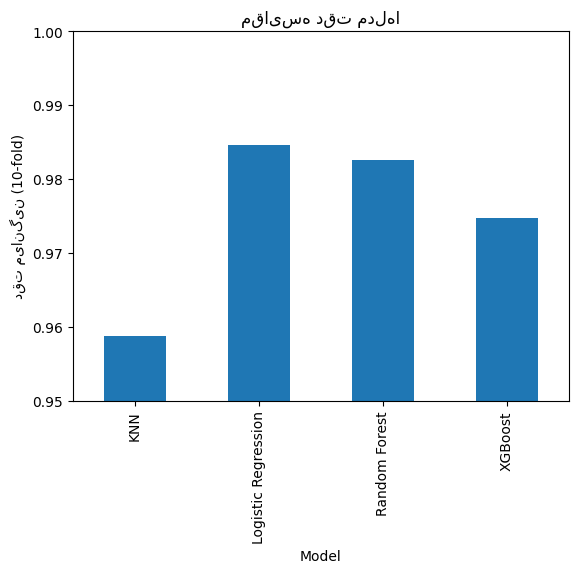

In [25]:
# مقایسه نتایج

results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Random Forest', 'XGBoost'],
    'Mean Accuracy': [knn_scores.mean(), lr_scores.mean(), rf_scores.mean(), xgb_scores.mean()],
    'Std Accuracy': [knn_scores.std(), lr_scores.std(), rf_scores.std(), xgb_scores.std()]
})
print(results)

results.plot(x='Model', y='Mean Accuracy', kind='bar', legend=False, ylim=(0.95, 1))
plt.title("مقایسه دقت مدل‌ها")
plt.ylabel('دقت میانگین (10-fold)')
plt.show()